<a href="https://colab.research.google.com/github/souken-b/calc_OWC/blob/main/calc_flowrate.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [174]:
import numpy as np
from sympy import *
import matplotlib.pyplot as plt
%matplotlib inline

In [175]:
def c_ci(d_ratio: 'diameter ratiodiameter')->'縮流係数（非圧縮性）':
  # flow coefficient
  f_coef = 0.598 - 0.003 * (d_ratio ** 2) + 0.404 * (d_ratio ** 4)
  return (f_coef / ((1 + (d_ratio ** 4) * (f_coef ** 2)) ** (1/2)))

In [176]:
def force_ci(c_ci: '縮流係数')->'力欠損係数（非圧縮）':
  return ((1 / c_ci) - (1 / (2 * (c_ci ** 2))))

In [177]:
def c_c(f_ci:'force coef', d_ratio, p_up, p_down, h_ratio)->'縮流係数（圧縮性）（fundamentals of pipeflow）':
  p_ratio = p_up / p_down
  h_ratio_rev = 1 / h_ratio
  Z = ((1 - h_ratio_rev) * (1- (1 / p_ratio))) / (1 - ((p_ratio) ** (h_ratio_rev - 1)))
  return ((1 - (1 - Z * ((-1) * (d_ratio ** 4 ) * Z + 2 * (d_ratio ** 2) + 2 * f_ci)) ** (1/2)) / (2 * (1 / (p_ratio ** (h_ratio_rev))) * ((-1) * (d_ratio ** 4) * (Z / 2) + (d_ratio ** 2) + f_ci)))

In [178]:
def c_c_2(f_ci: 'force coef', p_up, p_down, h_ratio)->'縮流係数（圧縮性）（圧縮性流体力学）':
  p_ratio = p_up / p_down
  h_ratio_rev = 1/ h_ratio 
  return ((1 / (2 * f_ci)) * (p_ratio ** h_ratio_rev) * (1 - (1 - ((2 * f_ci * (1 - h_ratio_rev)) * (1 - (1 / p_ratio)) / (1- (p_ratio) ** (h_ratio_rev - 1))))  ** (1/2)))

In [179]:
def upsilon(c_ci, c_c, d_ratio:'diameter ratio', p_up, p_down, h_ratio)-> '膨張補正係数':
  p_ratio = p_up / p_down
  h_ratio_rev = 1/ h_ratio
  return ((c_c / c_ci) * (((1 - (c_ci ** 2) * (d_ratio ** 4)) / (1 - (c_c ** 2) * (d_ratio ** 4) * ((1 / p_ratio) ** (2 * h_ratio_rev)))) ** (1/2)) * (((1 / (1 - h_ratio_rev)) * (((1 / p_ratio) ** (2 * h_ratio_rev)) - ((1 / p_ratio) ** (1 + h_ratio_rev))) / (1 - (1 / p_ratio))) ** (1 / 2)))

In [180]:
def f(q: 'flow_rate', n_diam: 'nozzle diameter', temp, p_up, p_down, n_ratio: 'nozzle ratio', h_ratio: 'specific heat ratio', flow_flg: 'flow direction flg', c_upsilon: '膨張補正係数') -> 'f(q)=aq^3+bq^2+q+d':
  # air viscosity rate(Pa・s)
  a_v_rate = 18.2 * 1e-6
  # air temparature(K)
  a_temp = 273 + 25
  # sutherland constant
  c_suther = 117
  # viscosity rate
  v_rate = a_v_rate * ((a_temp + c_suther) / (temp + c_suther)) * (temp / a_temp)**(3/2)
  # upstream density
  if (flow_flg):
    dens_up = (p_up * (28.93/1000)) / (8.3144 * temp)
  else:
    dens_up = 1.225
  c_lambda = (4/(pi*n_diam))*(dens_up/v_rate)
  # 膨張補正係数
  # exp_coef = 1-(0.41 + 0.35 * (n_ratio**2))*((p_up - p_down)/(h_ratio * p_up))
  # print(exp_coef)
  exp_coef = c_upsilon
  # print(exp_coef_2)
  H = (exp_coef ** 2) * ((pi*((n_diam / 2)**2)) ** 2) * 2 * (p_up - p_down) / dens_up
  # 実験値
  if (flow_flg):
    # forward flow
    A_0 = 0.601
    B = 22.7
    C = 815
    D = 1401
  else:
    # backward flow
    A_0 = 0.626
    B = 26.2
    C = 1733
    D = 2794
  
  coef_a = c_lambda ** 2
  coef_b = c_lambda * (B + C)
  coef_c = B * C - (c_lambda ** 2) * (A_0 ** 2) *  H
  coef_d = -(c_lambda * (A_0 ** 2) * D * H)
  return (coef_a * q ** 3 + coef_b * q ** 2 + coef_c * q +coef_d)



In [181]:
def newton_raphson(f, q1):
  fq = diff(f, q)
  threshold = 1e-6
  res = threshold + 1

  while res > threshold:
    q2 = float(q1 - (f.subs(q, q1) / fq.subs(q, q1)))
    res = np.abs(q2 - q1)
    q1 = q2
  return q2


In [182]:
def q_calc(a_0: 'area of upper flow', d_ratio: 'diameter ratio', p_up, p_down, c_c, h_ratio: 'heat ratio', flow_flg)->'圧縮性':
  h_ratio_rev = 1 / h_ratio
  if (flow_flg):
    dens_up = 1.225 * ((p_up / p_down) ** (h_ratio_rev))
    dens_down = 1.225
  else:
    dens_up = 1.225
    dens_down = 1.225 * ((p_down / p_up) ** (h_ratio_rev))
  p_ratio = p_up / p_down
  v_up = ((d_ratio ** 2) * c_c * (p_ratio ** (1 / h_ratio_rev)) * ((2 * (p_ratio ** (1- h_ratio_rev)) * (p_down / dens_down) * (1 - (p_ratio ** (h_ratio_rev - 1)))) ** (1 / 2)) / ((1 - (d_ratio ** 4) * (c_c ** 2) * (p_ratio ** (1 / (2 * h_ratio_rev))) ** (1/2))))
  return (a_0 * v_up)


In [183]:
def q_calc_i(a_0, c_ci, d_ratio, p_up, p_down, dens_air):
  p_ratio = p_up / p_down
  v_up = (d_ratio ** 2) * c_ci * ((2 * p_down * (p_ratio - 1) / dens_air)**(1/2)) / ((1 - (c_ci ** 2) * (d_ratio ** 4)) ** (1/2))
  return (a_0 * v_up)

In [184]:
q = Symbol('q')
n_diam = 2 * ((0.5183/pi) ** (1/2)) / 100
d_ratio = n_diam / (25.4 / 1000)
# d_ratio = (1 / 200) ** (1 / 2)
a_0 = pi * (((25.4 / (1000 * 2)) ** 2))
# a_0 = pi * (0.5 ** 2)
temp = 273 + 25
p_down = 101325 
n_ratio = d_ratio ** 2
h_ratio = 1.4

In [185]:
t_forward = np.linspace(0, np.pi, 500)
sin_list = np.sin(t_forward)
p1_list_in = [(1000*i + 101325 ) for i in sin_list]
q1_list_1_forward = []
q1_list_2_forward = []
q1_list_0_forward = []
q_calc_list_1_forward = []
q_calc_list_2_forward = []
q_list_i_forward = []

In [186]:
c_ci(d_ratio)

(0.103263664770246*pi**(-2.0)*(-0.000964039928079856*pi**(-1.0) + 0.0417185205671794*pi**(-2.0) + 0.598)**2 + 1)**(-0.5)*(-0.000964039928079856*pi**(-1.0) + 0.0417185205671794*pi**(-2.0) + 0.598)

In [187]:
for p1 in p1_list_in:
  c_ci_c = c_ci(d_ratio)
  f_ci_c = force_ci(c_ci_c)
  # fundamental of pipe flow
  c_c_c = c_c(f_ci_c, d_ratio, p1, p_down, h_ratio)
  # 圧縮性流体力学
  c_c_2_c = c_c_2(f_ci_c, p1, p_down, h_ratio) 
  c_upsilon_0 = 1-(0.41 + 0.35 * (n_ratio**2))*((p1 - p_down)/(h_ratio * p1)) 
  c_upsilon_1= upsilon(c_ci_c, c_c_c, d_ratio, p1, p_down, h_ratio) 
  c_upsilon_2 = upsilon(c_ci_c, c_c_2_c, d_ratio, p1, p_down, h_ratio) 
  q1 = newton_raphson(f(q, n_diam, temp, p1, p_down, n_ratio, h_ratio, True, c_upsilon_1), q1=0.0009) 
  q1_2 = newton_raphson(f(q, n_diam, temp, p1, p_down, n_ratio, h_ratio, True, c_upsilon_2), q1=0.0009) 
  q1_0 = newton_raphson(f(q, n_diam, temp, p1, p_down, n_ratio, h_ratio, True, c_upsilon_0), q1=0.0009)
  # q_calc_1 = q_calc(a_0, d_ratio, p1, 101325, c_c_c, h_ratio, True)
  # q_calc_2 = q_calc(a_0, d_ratio, p1, 101325, c_c_2_c, h_ratio, True)
  # q_i_0 = q_calc_i(a_0, c_ci_c, d_ratio, p1, 101325, 1.225)
  # print(q1_2)
  # print(q1_0)
  q1_list_0_forward.append(q1_0) 
  q1_list_1_forward.append(q1) 
  q1_list_2_forward.append(q1_2)
  # q_calc_list_1_forward.append(q_calc_1)
  # q_calc_list_2_forward.append(q_calc_2)
  # q_list_i_forward.append(q_i_0)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in double_scalars
  after removing the cwd from sys.path.


In [188]:
q1_list_cc_1_forward = [(i * 1e6) for i in q1_list_1_forward]
q1_list_cc_2_forward = [(i * 1e6) for i in q1_list_2_forward]
q1_list_cc_0_forward = [(i * 1e6) for i in q1_list_0_forward]
# q_calc_list_cc_1_forward = [(i) for i in q_calc_list_1_forward]
# q_calc_list_cc_2_forward = [(i) for i in q_calc_list_2_forward]
# q_list_i_cc_forward = [(i) for i in q_list_i_forward]

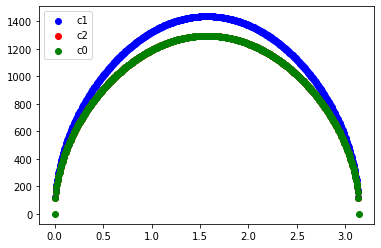

In [189]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.scatter(t_forward, q1_list_cc_1_forward, c='blue', label='c1')
ax.scatter(t_forward, q1_list_cc_2_forward, c='red', label='c2')
ax.scatter(t_forward, q1_list_cc_0_forward, c='green', label='c0')
# ax.scatter(t_forward, q_calc_list_cc_1_forward, c='orange', label='calc1')
# ax.scatter(t_forward, q_calc_list_cc_2_forward, c='yellow', label='calc2')
# ax.scatter(t_forward, q_list_i_cc_forward, c='black', label='incomp')
ax.legend(loc='upper left')
fig.show()

In [190]:
q = Symbol('q')
# d_ratio = (0.1022) ** (1 / 2)
d_ratio = (1 / 2000) ** (1 / 2)
n_diam = 0.0081235
temp = 273 + 20
p_up = 101325 
n_ratio = 0.1022
h_ratio = 1.4

In [191]:
t_back = np.linspace(np.pi, 2*np.pi, 500)
sin_list = np.sin(t_back)
p2_list_out = [(1000*i + 101325 ) for i in sin_list]
q1_list_1_back = []
q1_list_2_back = []
q1_list_0_back = []

In [192]:
for p2 in p2_list_out:
  c_ci_c = c_ci(d_ratio)
  f_ci_c = force_ci(c_ci_c)
  c_c_c = c_c(f_ci_c, d_ratio, p_down, p2, h_ratio)
  c_c_2_c = c_c_2(f_ci_c, p_down, p2, h_ratio)
  c_upsilon_0 = 1-(0.41 + 0.35 * (n_ratio**2))*((p_down - p2)/(h_ratio * p2))
  c_upsilon_1= upsilon(c_ci_c, c_c_c, d_ratio, p_down, p2, h_ratio)
  c_upsilon_2 = upsilon(c_ci_c, c_c_2_c, d_ratio, p_down, p2, h_ratio)
  q1 = newton_raphson(f(q, n_diam, temp, p_down, p2, n_ratio, h_ratio, True, c_upsilon_1), q1=0.0009)
  q1_2 = newton_raphson(f(q, n_diam, temp, p_down, p2, n_ratio, h_ratio, True, c_upsilon_2), q1=0.0009)
  q1_0 = newton_raphson(f(q, n_diam, temp, p_down, p2, n_ratio, h_ratio, True, c_upsilon_0), q1=0.0009)
  q1_list_0_back.append(q1_0)
  q1_list_1_back.append(q1)
  q1_list_2_back.append(q1_2)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in double_scalars
  after removing the cwd from sys.path.


In [193]:
q1_list_cc_1_back = [-(i * 1e6) for i in q1_list_1_back]
q1_list_cc_2_back = [-(i * 1e6) for i in q1_list_2_back]
q1_list_cc_0_back = [-(i * 1e6) for i in q1_list_0_back]

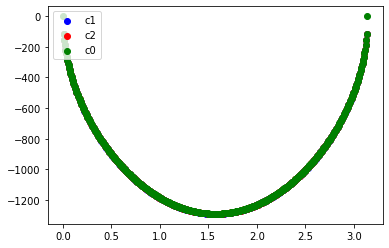

In [194]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.scatter(t_forward, q1_list_cc_1_back, c='blue', label='c1')
ax.scatter(t_forward, q1_list_cc_2_back, c='red', label='c2')
ax.scatter(t_forward, q1_list_cc_0_back, c='green', label='c0')
ax.legend(loc='upper left')
fig.show()

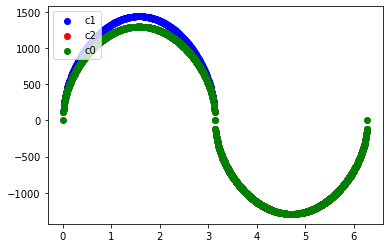

In [195]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.scatter(t_forward, q1_list_cc_1_forward, c='blue', label='c1')
ax.scatter(t_back, q1_list_cc_1_back, c='blue')
ax.scatter(t_forward, q1_list_cc_2_forward, c='red', label='c2')
ax.scatter(t_back, q1_list_cc_2_back, c='red')
ax.scatter(t_forward, q1_list_cc_0_forward, c='green', label='c0')
ax.scatter(t_back, q1_list_cc_0_back, c='green')
ax.legend(loc='upper left')
fig.show()